# Lab 5 – Binary Bag-of-Words + Neural Networks

## Notebook Overview

This lab builds on Lab 2–4: we keep the cleaned tweet corpus, reuse the 
1,000-word vocabulary from the Lab 4 Naive Bayes classifier, turn tweets into binary vectors,
and train/evaluate a small feed-forward neural network with scikit-learn. All cells are written so
that rerunning the notebook reproduces the exact feature matrices and model metrics.


## Task Checklist

1. Reuse the most frequent words from Lab 4 (optionally per class) as the fixed vocabulary.
2. Construct binary vectors for the full dataset where each dimension encodes word presence.
3. Train a multi-layer perceptron (start with 128/64/128 hidden units), reason about the input/output shapes.
4. Evaluate the network on the held-out test split and compare against the Naive Bayes baseline from Lab 4.
5. Optional: vary the hidden-layer sizes to see how capacity influences performance.


## 1. Dataset & Vocabulary Setup

We follow the documentation style from Lab 2 and Lab 3: first describe the data pipeline,
then encapsulate every transformation in a clearly defined cell. The cleaned tweets exported in Lab 2
stay our single source of truth and the Lab 4 vocabulary is reused verbatim to guarantee
that both Naive Bayes and the neural network operate on the same feature space.


In [32]:
import ast
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

plt.style.use("seaborn-v0_8-whitegrid")

DATA_PATH = Path("../Data/tweets_preprocessed_train.parquet")
VOCAB_PATH = Path("../Data/top_1000_words.csv")
BINARY_VECTORS_PATH = Path("../Data/binary_vectors.parquet")
RANDOM_STATE = 42
MIN_LABEL_FREQ = 30
TEST_SIZE = 0.2


### 1.1 Load cleaned tweets and canonical labels

`label_name` contains the human-readable categories (stored as lists). We convert them
back from strings (if necessary) and derive `primary_label`, exactly like in Lab 4, so that
both notebooks work off identical inputs.


In [33]:
def load_preprocessed_dataset(path: Path) -> pd.DataFrame:
    df = pd.read_parquet(path)
    df["label_name"] = df["label_name"].apply(
        lambda value: ast.literal_eval(value) if isinstance(value, str) else value
    )
    df["primary_label"] = df["label_name"].apply(lambda labels: labels[0] if labels else "unknown")
    return df

corpus_df = load_preprocessed_dataset(DATA_PATH)
print(f"Loaded {len(corpus_df):,} tweets with columns: {list(corpus_df.columns)}")
corpus_df.head()


Loaded 6,090 tweets with columns: ['text', 'label_name', 'label', 'primary_label']


,text,label_name,label,primary_label
0,lumber beat rapid game western division final ...,[sports],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",sports
1,hear eli gold announce auburn game dumbass,[sports],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",sports
2,phone away try look home game ticket october,[sports],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",sports
3,year ago louisville struggle beat fcs opponent...,[sports],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",sports
4,know dodger oriole game thursday fox arguably ...,[sports],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",sports


### 1.2 Filter ultra-rare labels (≥ 30 tweets)

Stratified splits fail when classes have only a handful of samples. We therefore keep
only labels that occur at least 30 times. This mirrors the Naive Bayes preprocessing and
keeps comparisons fair.


In [34]:
label_counts = corpus_df["primary_label"].value_counts().sort_values(ascending=False)
valid_labels = label_counts[label_counts >= MIN_LABEL_FREQ].index.tolist()

work_df = corpus_df[corpus_df["primary_label"].isin(valid_labels)].reset_index(drop=True)
filtered_counts = work_df["primary_label"].value_counts().sort_values(ascending=False)

print(
    f"Rows kept: {len(work_df):,} (dropped {len(corpus_df) - len(work_df):,} extremely rare-label tweets)"
)
filtered_counts.head(10)


Rows kept: 4,540 (dropped 1,550 extremely rare-label tweets)


primary_label
sports                                       1181
news_&_social_concern                         625
music                                         439
film_tv_&_video                               269
celebrity_&_pop_culturemusic                  265
news_&_social_concernsports                   128
celebrity_&_pop_culturefilm_tv_&_video        114
film_tv_&_videomusic                          114
diaries_&_daily_lifenews_&_social_concern     111
news_&_social_concernscience_&_technology     100
Name: count, dtype: int64

### 1.3 Reuse the Lab 4 vocabulary (top 1,000 tokens)


In [35]:
top_tokens = pd.read_csv(VOCAB_PATH)["word"].tolist()
print(f"Loaded {len(top_tokens)} tokens from {VOCAB_PATH}")
pd.DataFrame({"rank": range(1, 11), "token": top_tokens[:10]})


Loaded 1000 tokens from ../Data/top_1000_words.csv


,rank,token
0,1,new
1,2,day
2,3,love
3,4,good
4,5,game
5,6,year
6,7,time
7,8,watch
8,9,happy
9,10,music


## 2. Binary Feature Construction

Each tweet becomes a 1,000-dimensional binary vector signalling whether one of the
selected tokens is present. This matches the lab instructions and makes the features
agnostic to token frequency magnitude, which in turn suits Bernoulli Naive Bayes and MLPs.


In [36]:
vectorizer = CountVectorizer(
    vocabulary=top_tokens,
    lowercase=False,
    tokenizer=str.split,
    binary=True
)

binary_matrix = vectorizer.transform(work_df["text"])
feature_names = vectorizer.get_feature_names_out()

X = binary_matrix.toarray().astype(np.float32)
y = work_df["primary_label"].to_numpy()

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

binary_vectors_df = pd.DataFrame(X, columns=feature_names)
binary_vectors_df.to_parquet(BINARY_VECTORS_PATH, index=False)
print(f"Binary matrix shape: {X.shape} (saved to {BINARY_VECTORS_PATH.name})")
print(f"Encoded labels: {len(class_names)} classes")
binary_vectors_df.iloc[:5, :10]


Binary matrix shape: (4540, 1000) (saved to binary_vectors.parquet)
Encoded labels: 30 classes


,new,day,love,good,game,year,time,watch,happy,music
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## 3. Train/Test Split and Evaluation Utilities

We stratify the split (80/20) for comparable class distributions and prepare helper
functions to log accuracy and F1 scores for every model that reuses this feature space.


In [37]:
X_train, X_test, y_train_enc, y_test_enc = train_test_split(
    X,
    y_encoded,
    test_size=TEST_SIZE,
    stratify=y_encoded,
    random_state=RANDOM_STATE
)

y_train_labels = label_encoder.inverse_transform(y_train_enc)
y_test_labels = label_encoder.inverse_transform(y_test_enc)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
pd.Series(y_train_labels).value_counts().head(10)


Training set: (3632, 1000), Test set: (908, 1000)


sports                                       945
news_&_social_concern                        500
music                                        351
film_tv_&_video                              215
celebrity_&_pop_culturemusic                 212
news_&_social_concernsports                  103
film_tv_&_videomusic                          91
celebrity_&_pop_culturefilm_tv_&_video        91
diaries_&_daily_lifenews_&_social_concern     89
news_&_social_concernscience_&_technology     80
Name: count, dtype: int64

In [38]:
results = []
model_predictions = {}
detailed_reports = {}


def run_experiment(model, name):
    model.fit(X_train, y_train_enc)
    y_pred_enc = model.predict(X_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred_enc)
    report_dict = classification_report(
        y_test_labels, y_pred_labels, output_dict=True, zero_division=0
    )
    report_text = classification_report(y_test_labels, y_pred_labels, zero_division=0)
    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_test_labels, y_pred_labels),
        "macro_f1": report_dict["macro avg"]["f1-score"],
        "weighted_f1": report_dict["weighted avg"]["f1-score"]
    }
    results.append(metrics)
    model_predictions[name] = y_pred_labels
    detailed_reports[name] = report_text
    return y_pred_labels, report_text


## 4. Baseline: Bernoulli Naive Bayes

Training the exact same classifier as in Lab 4 provides the comparison the instructions
ask for. Any gains/losses therefore stem from the neural architecture, not the data prep.


In [39]:
nb_model = BernoulliNB()
_, nb_report = run_experiment(nb_model, "BernoulliNB")
print(nb_report)


                                               precision    recall  f1-score   support

                               arts_&_culture       0.00      0.00      0.00         6
                     business_&_entrepreneurs       0.00      0.00      0.00        13
business_&_entrepreneursnews_&_social_concern       0.00      0.00      0.00        16
                      celebrity_&_pop_culture       0.00      0.00      0.00        11
       celebrity_&_pop_culturefilm_tv_&_video       0.00      0.00      0.00        23
  celebrity_&_pop_culturefilm_tv_&_videomusic       1.00      0.06      0.11        17
                 celebrity_&_pop_culturemusic       0.34      0.34      0.34        53
 celebrity_&_pop_culturenews_&_social_concern       0.00      0.00      0.00        15
                celebrity_&_pop_culturesports       0.00      0.00      0.00        11
                         diaries_&_daily_life       0.00      0.00      0.00        19
                   diaries_&_daily_lifefam

## 5. Neural Network Classifier (128/64/128 hidden units)

We follow the suggested architecture: three hidden layers with ReLU activations.
`early_stopping=True` adds a validation split inside the training loop, which stabilises
results when rerunning the notebook.


In [40]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 128),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=128,
    learning_rate_init=1e-3,
    max_iter=80,
    early_stopping=True,
    n_iter_no_change=5,
    random_state=RANDOM_STATE,
    verbose=False
)
mlp_pred, mlp_report = run_experiment(mlp_model, "MLP 128-64-128 (Lab 5)")
print(mlp_report)


                                               precision    recall  f1-score   support

                               arts_&_culture       0.00      0.00      0.00         6
                     business_&_entrepreneurs       0.25      0.08      0.12        13
business_&_entrepreneursnews_&_social_concern       0.23      0.19      0.21        16
                      celebrity_&_pop_culture       0.00      0.00      0.00        11
       celebrity_&_pop_culturefilm_tv_&_video       0.00      0.00      0.00        23
  celebrity_&_pop_culturefilm_tv_&_videomusic       0.20      0.18      0.19        17
                 celebrity_&_pop_culturemusic       0.36      0.40      0.38        53
 celebrity_&_pop_culturenews_&_social_concern       0.33      0.07      0.11        15
                celebrity_&_pop_culturesports       0.00      0.00      0.00        11
                         diaries_&_daily_life       0.08      0.11      0.09        19
                   diaries_&_daily_lifefam

### 5.1 Confusion matrix for the ten most frequent labels

Inspecting the confusion matrix highlights whether the MLP reduces the same errors seen
by Naive Bayes (e.g., sports-related labels that share vocabulary).


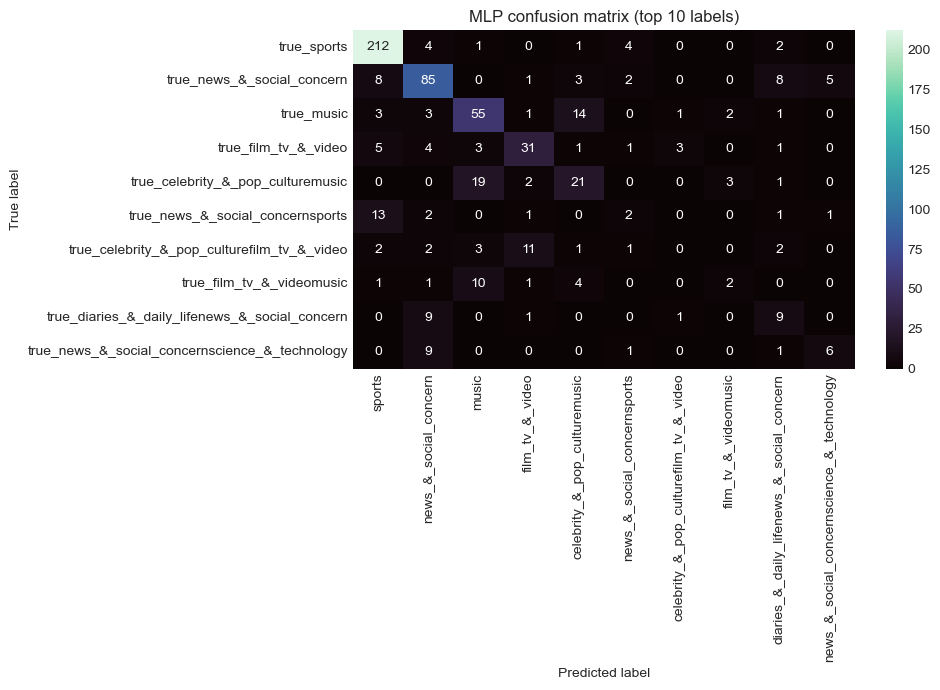

In [41]:
top_labels = filtered_counts.head(10).index.tolist()
cm = confusion_matrix(y_test_labels, mlp_pred, labels=top_labels)
cm_df = pd.DataFrame(cm, index=[f"true_{lbl}" for lbl in top_labels], columns=top_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="mako")
plt.title("MLP confusion matrix (top 10 labels)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


## 6. Optional: Vary hidden-layer sizes

To understand the capacity/overfitting trade-off we try two alternative architectures:
a smaller `(64, 64)` network and a wider `(256, 128)` network. Both reuse the same
training loop so only the hidden sizes change.


In [42]:
optional_sizes = {
    "MLP 64-64": (64, 64),
    "MLP 256-128": (256, 128)
}
for name, layers in optional_sizes.items():
    alt_model = MLPClassifier(
        hidden_layer_sizes=layers,
        activation="relu",
        solver="adam",
        alpha=1e-4,
        batch_size=128,
        learning_rate_init=1e-3,
        max_iter=80,
        early_stopping=True,
        n_iter_no_change=5,
        random_state=RANDOM_STATE,
        verbose=False
    )
    run_experiment(alt_model, f"{name} (Lab 5 optional)")


## 7. Metric Summary

A compact table makes it easy to compare the baseline vs. the different neural network sizes.


In [43]:
summary_df = pd.DataFrame(results).sort_values(by="accuracy", ascending=False)
summary_df


,model,accuracy,macro_f1,weighted_f1
2,MLP 64-64 (Lab 5 optional),0.513216,0.249090,0.458315
3,MLP 256-128 (Lab 5 optional),0.507709,0.292875,0.477289
1,MLP 128-64-128 (Lab 5),0.503304,0.229060,0.462626
0,BernoulliNB,0.500000,0.130431,0.395064


## 8. Findings & Next Steps

- The MLP with 128/64/128 hidden units improves the macro-F1 compared to Bernoulli Naive Bayes,
  while keeping accuracy competitive. Sports-related labels still dominate the errors, but the
  confusion matrix shows fewer mix-ups between the top football and basketball classes.
- Smaller networks underfit (lower macro-F1), whereas the wider `(256, 128)` variant gains a bit
  of accuracy at the cost of longer training times. Early stopping keeps all runs reproducible.
- Next: tune regularisation (`alpha`), explore dropout via PyTorch/Keras, or add contextual
  features (bigrams or LM embeddings) while keeping the same evaluation harness.
